!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [1]:
# Lib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [2]:
# Load the time series data
df = pd.read_csv("../epidemic_curve.csv")
df.head()


,date,cases
0,2024-01-01,0
1,2024-01-08,0
2,2024-01-15,46
3,2024-01-22,40
4,2024-01-29,3


In [3]:
# Prepare the data for Chronos
'''
Extract the numeric series (the cases column) and convert it to a PyTorch tensor. 

Chronos expects a 1D tensor (or a batch of 1D tensors) as input.
'''

context=torch.tensor(df["cases"].values, dtype=torch.float32)

In [4]:
context.shape # This creates context, a 1D tensor of length 40 (for 40 weeks)

torch.Size([40])

In [5]:
# Load the pre-trained Chronos model
'''
Use ChronosPipeline.from_pretrained to load the Chronos-T5 model.

The resulting pipeline object encapsulates the model and will be used for prediction.
'''
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps") # This will download the amazon/chronos-t5-small model and initialize a forecasting pipeline
# Also i can use device_map="auto" to use GPU if available or device_map="mps" for my MacBook laptop


model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [6]:
# Forecast the next 4 weeks
'''
Call pipeline.predict with the context tensor and prediction_length=4 to forecast the next 4 time steps.
'''

prediction_length = 4
forecast = pipeline.predict(context, prediction_length) # shape [num_series, num_samples, prediction_length]


In [7]:
forecast.shape # This creates forecast, a 1D tensor of length 4 (for 4 predicted weeks)

torch.Size([1, 20, 4])

This runs the model to predict 4 future weekly values. Internally, Chronos generates many sample trajectories; as shown above, the output forecast will have shape `[num_series, num_samples, prediction_length]`. 

Here **num_series=1 (one time series)** and **prediction_length=4**. 

For example, if the default num_samples is 20, then forecast.shape would be (1, 20, 4).

In [8]:
forecast[0] # (shape [num_samples, 4]) to see all sampled forecasts. The predicted values for the next 4 weeks

tensor([[7.0726e-06, 1.8558e+01, 4.8252e+01, 7.0726e-06],
        [1.2249e+02, 7.4234e+01, 7.0726e-06, 3.3405e+01],
        [2.2270e+01, 7.0726e-06, 1.1135e+01, 7.0726e-06],
        [7.0522e+01, 7.4234e+00, 9.2792e+01, 7.0522e+01],
        [7.0726e-06, 7.0726e-06, 7.0726e-06, 7.0726e-06],
        [7.0726e-06, 7.0726e-06, 1.1135e+01, 1.4847e+01],
        [7.0726e-06, 4.8252e+01, 4.0829e+01, 3.7117e+00],
        [7.0726e-06, 7.0726e-06, 7.0726e-06, 7.0726e-06],
        [7.0726e-06, 2.2270e+01, 1.4847e+01, 7.4234e+00],
        [1.0764e+02, 1.4847e+02, 1.2249e+02, 1.4104e+02],
        [1.1135e+01, 5.1964e+01, 3.7117e+00, 4.0829e+01],
        [3.7117e+00, 7.0726e-06, 7.0726e-06, 7.0726e-06],
        [7.0726e-06, 7.0726e-06, 7.0726e-06, 7.0726e-06],
        [4.8252e+01, 5.9387e+01, 5.9387e+01, 1.4847e+01],
        [3.3405e+01, 1.1135e+01, 7.0726e-06, 7.0726e-06],
        [7.0726e-06, 7.0726e-06, 5.1964e+01, 1.0393e+02],
        [1.1135e+01, 7.0726e-06, 1.8558e+01, 8.1657e+01],
        [7.072

In [9]:
# Chronos produces a distribution of future values
# Visualize the forecast

forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

print("Low (10th percentile) forecast for next 4 weeks:", low)
print("Median (50th percentile) forecast for next 4 weeks:", median)
print("High (90th percentile) forecast for next 4 weeks:", high)


Low (10th percentile) forecast for next 4 weeks: [7.07258005e-06 7.07258005e-06 7.07258005e-06 7.07258005e-06]
Median (50th percentile) forecast for next 4 weeks: [ 3.71170068  5.56754744 11.13508797  3.71170068]
High (90th percentile) forecast for next 4 weeks: [84.25545044 60.87178078 62.72762871 83.8842804 ]


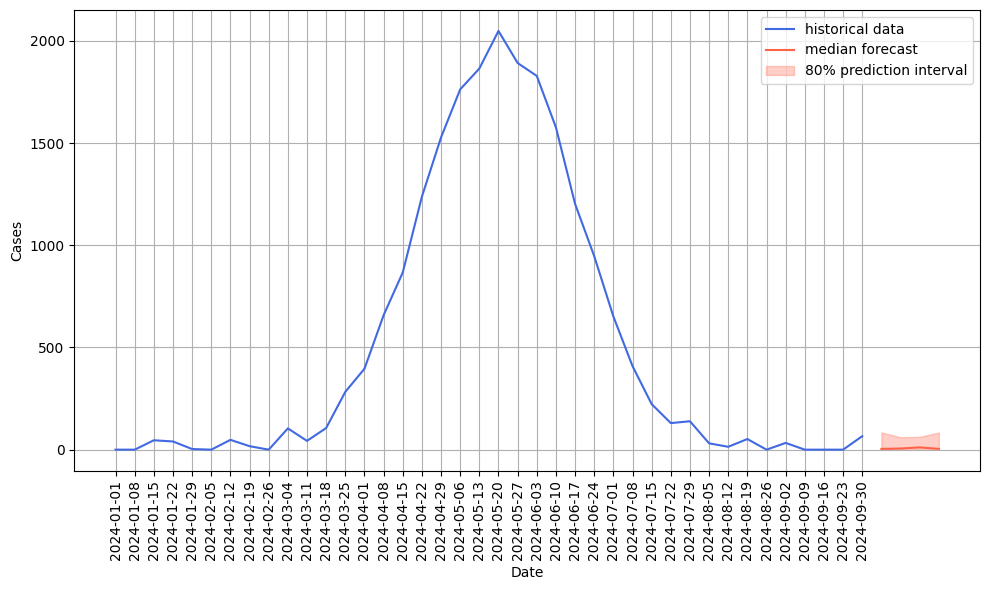

In [10]:
# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="historical data")
#plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")

plt.xlabel("Date")
plt.xticks(rotation=90)

plt.ylabel("Cases")

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

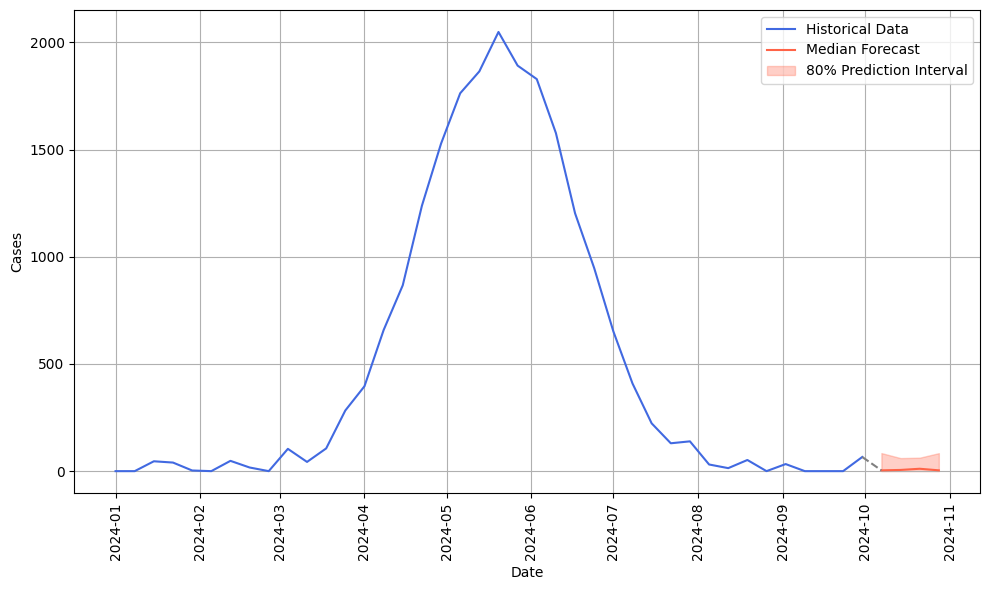

In [11]:
# Ensure 'date' is datetime
df["date"] = pd.to_datetime(df["date"])

# Existing values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Create forecast_dates: next 4 weeks after last date
forecast_dates = pd.date_range(start=df["date"].iloc[-1] + pd.Timedelta(weeks=1),
                               periods=prediction_length, freq="W-MON")

# Combine all dates for x-axis
full_dates = pd.concat([df["date"], pd.Series(forecast_dates)])

# Combine all values for plotting reference line (optional)
full_cases = pd.concat([df["cases"], pd.Series([None]*prediction_length)])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=90)
plt.grid()
plt.legend()
plt.tight_layout()

# Add this before plt.show()
plt.plot([df["date"].iloc[-1], forecast_dates[0]],
         [df["cases"].iloc[-1], median[0]],
         color="gray", linestyle="--", label="Forecast Start")

plt.show()




In [12]:
# Print forecasted 4 weeks with dates
print("\nForecasted Cases (Next 4 Weeks):")
for d, c in zip(forecast_dates, median):
    print(f"{d.strftime('%Y-%m-%d')}: {round(c, 2)} cases")


Forecasted Cases (Next 4 Weeks):
2024-10-07: 3.71 cases
2024-10-14: 5.57 cases
2024-10-21: 11.14 cases
2024-10-28: 3.71 cases
